<a href="https://colab.research.google.com/github/poojagupta14/Energy_Consumption_Prediction_Model/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
copied_path = 'drive/MyDrive/AEP_hourly.csv' 
df = pd.read_csv(copied_path)

In [50]:
# To extract all data like Year MOnth Day Time etc.

df["Month"] = pd.to_datetime(df["Datetime"]).dt.month
df["Year"] = pd.to_datetime(df["Datetime"]).dt.year
df["Date"] = pd.to_datetime(df["Datetime"]).dt.date
df["Time"] = pd.to_datetime(df["Datetime"]).dt.time
df["Week"] = pd.to_datetime(df["Datetime"]).dt.week
df["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday


In [12]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [19]:
# Resampling data
dfNew = df.resample('D').mean()
print("Old Dataset ",df.shape )
print("New  Dataset ",dfNew.shape )

Old Dataset  (121273, 7)
New  Dataset  (5055, 4)


In [21]:
test_data = dfNew.tail(100)

train_data = dfNew.iloc[:,0:1]

train_data = train_data[:-60]

print("Training Data Shape ", train_data.shape)
print("Testing Data Shape ", test_data.shape)

Training Data Shape  (4995, 1)
Testing Data Shape  (100, 4)


In [23]:
type(train_data.values)

numpy.ndarray

In [26]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_data = sc.fit_transform(train_data)

In [28]:
X_Train = []
Y_Train = []

# Range should be fromm 60 values to end
for i in range(60, train_data.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(train_data[i-60:i])
    
    # Y would be 60th value based on past 60 values 
    Y_Train.append(train_data[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


In [29]:
# Shape will be number of (datapoints , steps , 1 )
# We convert into 3-d Vector or #rd dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

In [30]:
# Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [31]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [32]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 [==============================] - 51s 263ms/step - loss: 0.0227
Epoch 2/50
155/155 [==============================] - 41s 262ms/step - loss: 0.0182
Epoch 3/50
155/155 [==============================] - 41s 265ms/step - loss: 0.0167
Epoch 4/50
155/155 [==============================] - 41s 262ms/step - loss: 0.0162
Epoch 5/50
155/155 [==============================] - 41s 266ms/step - loss: 0.0159
Epoch 6/50
155/155 [==============================] - 41s 264ms/step - loss: 0.0149
Epoch 7/50
155/155 [==============================] - 40s 260ms/step - loss: 0.0142
Epoch 8/50
155/155 [==============================] - 41s 262ms/step - loss: 0.0116
Epoch 9/50
155/155 [==============================] - 40s 261ms/step - loss: 0.0099
Epoch 10/50
155/155 [==============================] - 40s 261ms/step - loss: 0.0091
Epoch 11/50
155/155 [==============================] - 41s 264ms/step - loss: 0.0086
Epoch 12/50
155/155 [==============================] - 41s 261ms/step - lo

In [33]:
test_data.head()

,AEP_MW,Month,Year,Week
Datetime,,,,
2018-04-26,13157.791667,4,2018,17
2018-04-27,12964.000000,4,2018,17
2018-04-28,12237.583333,4,2018,17
2018-04-29,12156.791667,4,2018,17
2018-04-30,13443.500000,4,2018,18


In [34]:
test_data.shape

(100, 4)

In [36]:
dfNew.shape

(5055, 4)

In [39]:
data = pd.concat((dfNew[["AEP_MW"]], test_data[["AEP_MW"]]), axis=0)
data.shape

(5155, 1)

In [41]:
input = data[len(data) - len(test_data) - 60:].values
input.shape

(160, 1)

In [42]:
input = data[len(data) - len(test_data) - 60:].values

# We need to Reshape
input = input.reshape(-1,1)

# Normalize the Dataset
input = sc.transform(input)

X_test = []
for i in range(60, 160):
    X_test.append(input[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_stock_price = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [44]:
True_MegaWatt = test_data["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_stock_price
dates = test_data.index.to_list()

In [45]:
Df = pd.DataFrame(data={"Date":dates, "TrueMegaWatt":True_MegaWatt, "PredictedMeagWatt":[x[0] for x in Predicted_MegaWatt]})

In [46]:
Df

,Date,TrueMegaWatt,PredictedMeagWatt
0,2018-04-26,13157.791667,13724.773438
1,2018-04-27,12964.000000,13094.065430
2,2018-04-28,12237.583333,14945.481445
3,2018-04-29,12156.791667,13462.718750
4,2018-04-30,13443.500000,12950.017578
...,...,...,...
95,2018-07-30,15368.083333,15681.756836
96,2018-07-31,15180.291667,15707.306641
97,2018-08-01,15151.166667,15200.417969
98,2018-08-02,15687.666667,15332.129883


In [47]:
True_MegaWatt = test_data["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = test_data.index.to_list()

No handles with labels found to put in legend.


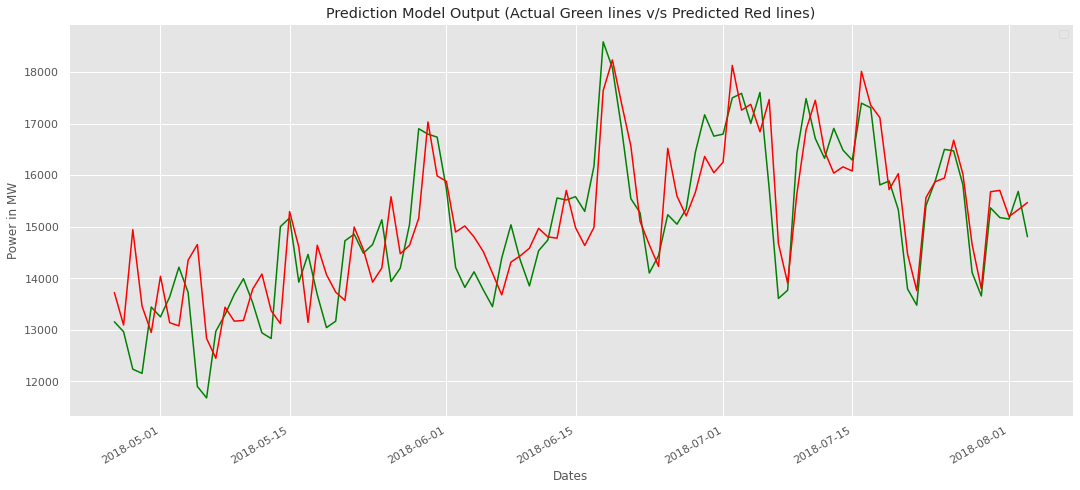

In [48]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = Predicted_MegaWatt

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Prediction Model Output (Actual Green lines v/s Predicted Red lines)")
plt.legend()